In [73]:
import pytorch_lightning
from monai.utils import set_determinism
from monai.transforms import (
    AsDiscrete,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LabelToContour,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    EnsureType,
    ThresholdIntensityd,
    RandAxisFlipd,
    RandBiasFieldd,
    AddChanneld,
    MaskIntensityd,
    ScaleIntensityd,
    RandFlipd,
    ToTensord,
    Resized,
    RandRotate90d,
    RandGaussianNoised,
    RandRotated,
    RandGaussianSmoothd,
    RandKSpaceSpikeNoised,
    RandCoarseDropoutd,
    NormalizeIntensityd,
    AdjustContrastd,
    FillHoles
)
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceCELoss, DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, list_data_collate, decollate_batch, DataLoader
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import random
import shutil
import os
import glob
import numpy as np

In [74]:
os.chdir('/home/sisyphe/sol-test/MONAI')
inputs=np.load('/home/sisyphe/sol-test/BB_Labels_formats_divers/Format_Image/1_Rond_Gris/inputs_512.npy')
labels=np.load('/home/sisyphe/sol-test/BB_Labels_formats_divers/Format_Image/1_Rond_Gris/labels_512.npy')
device = torch.device("cuda:0")

In [75]:
class ShoulderNet(pytorch_lightning.LightningModule):
    def __init__(self):
        super().__init__()
        self._model = UNet(
            spatial_dims=2,
            in_channels=1,
            out_channels=2,
            channels=(16, 32, 64, 128, 256),
            strides=(1, 1, 1, 1),
            num_res_units=2,
            norm=Norm.BATCH,
            act='softmax'
        )
        self.loss_function = DiceCELoss(include_background=True, to_onehot_y=True, softmax=True)
        self.post_pred = Compose([FillHoles(),
                                EnsureType("tensor", device="cpu"),
                                AsDiscrete(argmax=True, to_onehot=2)])
        self.post_label = Compose([EnsureType("tensor", device="cpu"), AsDiscrete(to_onehot=2)])
        self.dice_metric = DiceMetric(include_background=True, reduction='mean', get_not_nans=False)
        self.best_val_dice = 0
        self.best_val_epoch = 0
    
    def forward(self, x):
        return self._model(x)

    def prepare_data(self):
        data_dicts = [
            {"image": image_name, "label": label_name}
            for image_name, label_name in zip(inputs, labels)
        ]
        train_files, val_files = data_dicts[:-20], data_dicts[-20:]
        set_determinism(seed=0)
        train_transforms = Compose([
        AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        NormalizeIntensityd(keys=['image']),
        RandGaussianNoised(keys=["image", "label"], prob=0.2),
        RandRotated(keys=["image", "label"], prob=0.2),
        RandGaussianSmoothd(keys=["image", "label"], prob=0.2),
        RandKSpaceSpikeNoised(keys=["image", "label"], prob=0.2),
        RandCoarseDropoutd(keys=["image", "label"], prob=0.2, holes=50, spatial_size=20),
        ToTensord(keys=["image", "label"], dtype=torch.float)
        ])
        val_transforms = Compose(
        [
        AddChanneld(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        NormalizeIntensityd(keys=['image']),
        ToTensord(keys=["image", "label"], dtype=torch.float)
        ])
        
        self.train_ds = CacheDataset(
            data=train_files, transform=train_transforms,
            cache_rate=1.0, num_workers=4,
        )
        self.val_ds = CacheDataset(
            data=val_files, transform=val_transforms,
            cache_rate=1.0, num_workers=4,
        )
    def train_dataloader(self):
        train_loader = DataLoader(
            self.train_ds, shuffle=True,
            num_workers=4, collate_fn=list_data_collate,
        )
        return train_loader

    def val_dataloader(self):
        val_loader = DataLoader(
            self.val_ds, num_workers=4)
        return val_loader
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self._model.parameters(), 1e-4)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        images, labels = batch["image"].to(device), batch["label"].to(device)
        output = self.forward(images)
        loss = self.loss_function(output, labels)
        tensorboard_logs = {"train_loss": loss.item()}
        self.log("train_loss", loss.item())
        return {"loss": loss, "log": tensorboard_logs}
    
    def validation_step(self, batch, batch_idx):
        images, labels = batch["image"].to(device), batch["label"].to(device)
        roi_size = (512, 512)
        sw_batch_size = 4
        outputs = sliding_window_inference(
            images, roi_size, sw_batch_size, self.forward)
        loss = self.loss_function(outputs, labels)
        outputs = [self.post_pred(i) for i in decollate_batch(outputs)]
        labels = [self.post_label(i) for i in decollate_batch(labels)]
        self.dice_metric(y_pred=outputs, y=labels)
        return {"val_loss": loss, "val_number": len(outputs)}
    
    def validation_epoch_end(self, outputs):
        val_loss, num_items = 0, 0
        for output in outputs:
            val_loss += output["val_loss"].sum().item()
            num_items += output["val_number"]
        mean_val_dice = self.dice_metric.aggregate().item()
        self.dice_metric.reset()
        mean_val_loss = torch.tensor(val_loss / num_items)
        tensorboard_logs = {
            "val_dice": mean_val_dice,
            "val_loss": mean_val_loss,
        }
        self.log("val_dice", mean_val_dice)
        self.log("val_loss", mean_val_loss)
        if mean_val_dice > self.best_val_dice:
            self.best_val_dice = mean_val_dice
            self.best_val_epoch = self.current_epoch
        print(
            f"current epoch: {self.current_epoch} "
            f"current mean dice: {mean_val_dice:.4f}"
            f"\nbest mean dice: {self.best_val_dice:.4f} "
            f"at epoch: {self.best_val_epoch}"
        )
        return {"log": tensorboard_logs}
    

In [76]:
# initialise the LightningModule
net = ShoulderNet()

# set up loggers and checkpoints
log_dir = os.path.join('/home/sisyphe/sol-test/MONAI/3', "logs")
tb_logger = pytorch_lightning.loggers.TensorBoardLogger(
    save_dir=log_dir
)

# initialise Lightning's trainer.
trainer = pytorch_lightning.Trainer(
    gpus=1,
    max_epochs=10,
    logger=tb_logger,
    enable_checkpointing=True,
    num_sanity_val_steps=0,
    log_every_n_steps=10,
    fast_dev_run=False,
#    overfit_batches=10
)

# train
trainer.fit(net)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Loading dataset: 100%|██████████| 20/20 [00:00<00:00, 76.02it/s]
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name          | Type       | Params
---------------------------------------------
0 | _model        | UNet       | 1.5 M 
1 | loss_function | DiceCELoss | 0     
---------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
6.166     Total estimated model params size (MB)


Epoch 0: 100%|██████████| 164/164 [01:18<00:00,  2.10it/s, loss=0.887, v_num=5]current epoch: 0 current mean dice: 0.7509
best mean dice: 0.7509 at epoch: 0
Epoch 1: 100%|██████████| 164/164 [01:12<00:00,  2.27it/s, loss=0.768, v_num=5]current epoch: 1 current mean dice: 0.8121
best mean dice: 0.8121 at epoch: 1
Epoch 2: 100%|██████████| 164/164 [01:18<00:00,  2.10it/s, loss=0.709, v_num=5]current epoch: 2 current mean dice: 0.8091
best mean dice: 0.8121 at epoch: 1
Epoch 3: 100%|██████████| 164/164 [01:12<00:00,  2.25it/s, loss=0.638, v_num=5]current epoch: 3 current mean dice: 0.8295
best mean dice: 0.8295 at epoch: 3
Epoch 4: 100%|██████████| 164/164 [01:18<00:00,  2.09it/s, loss=0.601, v_num=5]current epoch: 4 current mean dice: 0.8408
best mean dice: 0.8408 at epoch: 4
Epoch 5: 100%|██████████| 164/164 [01:15<00:00,  2.18it/s, loss=0.615, v_num=5]current epoch: 5 current mean dice: 0.8327
best mean dice: 0.8408 at epoch: 4
Epoch 6: 100%|██████████| 164/164 [01:16<00:00,  2.15it/s,

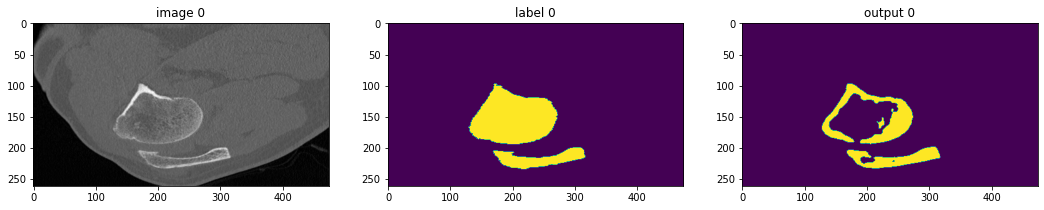

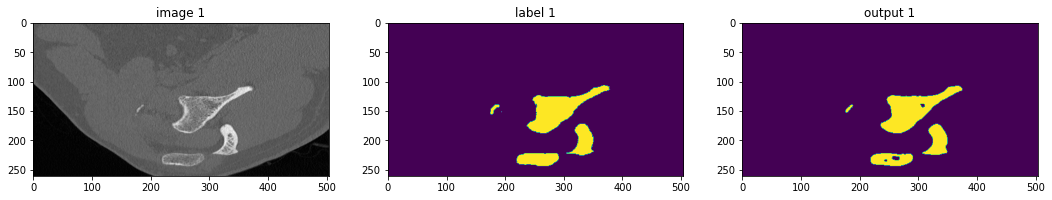

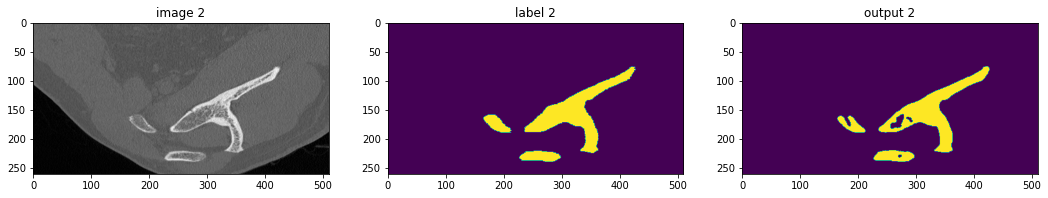

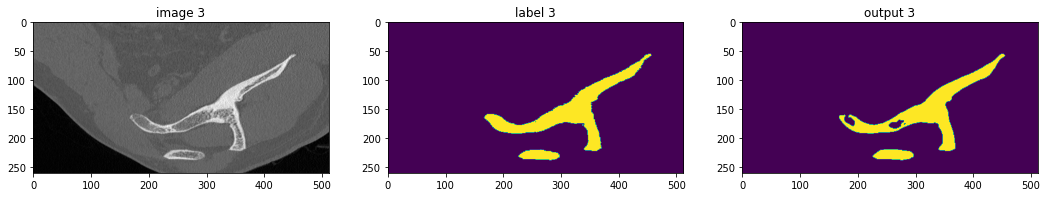

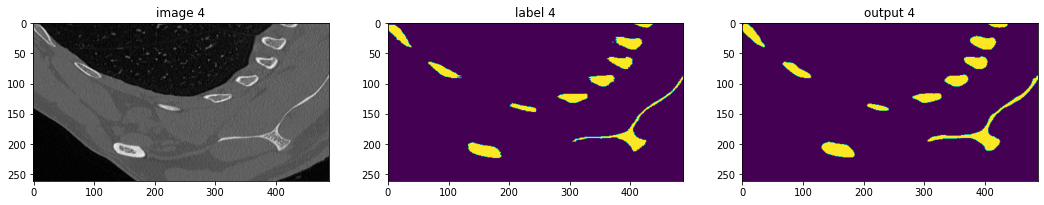

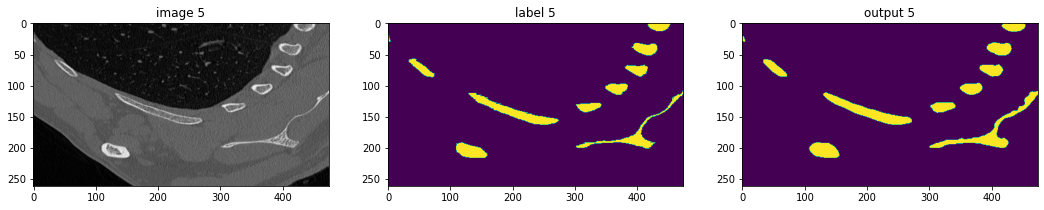

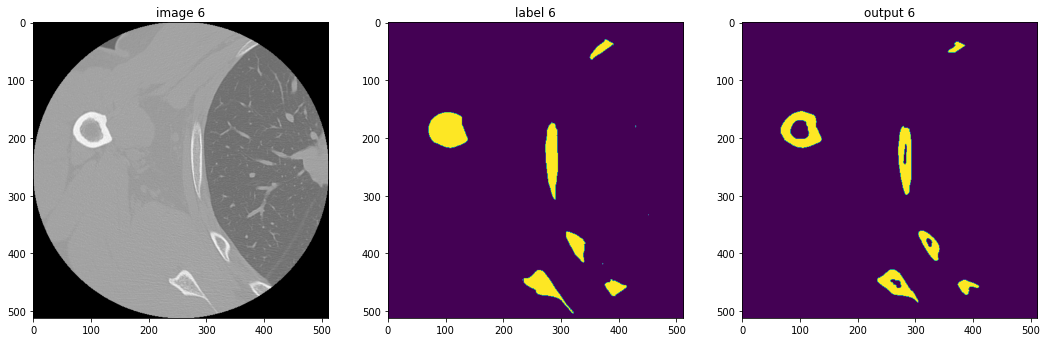

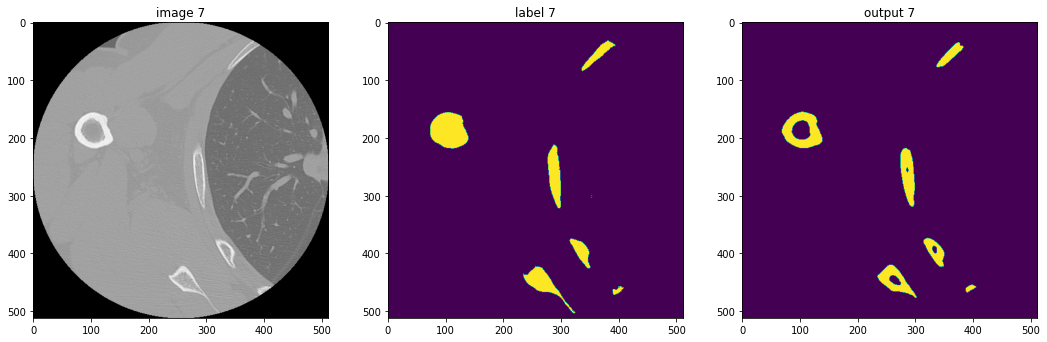

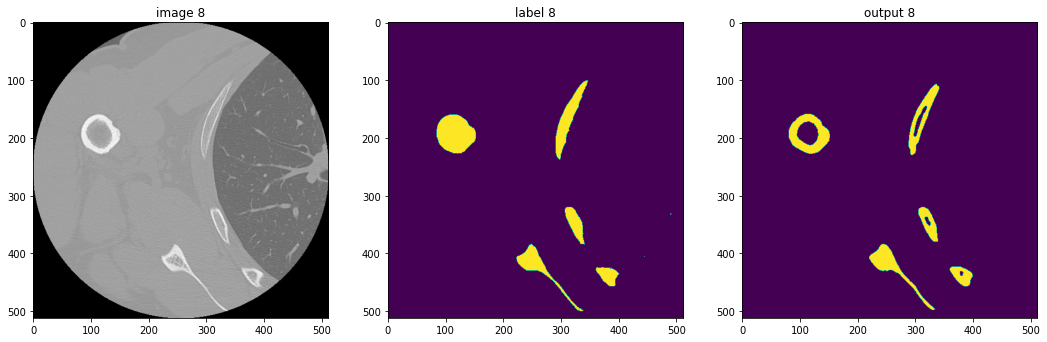

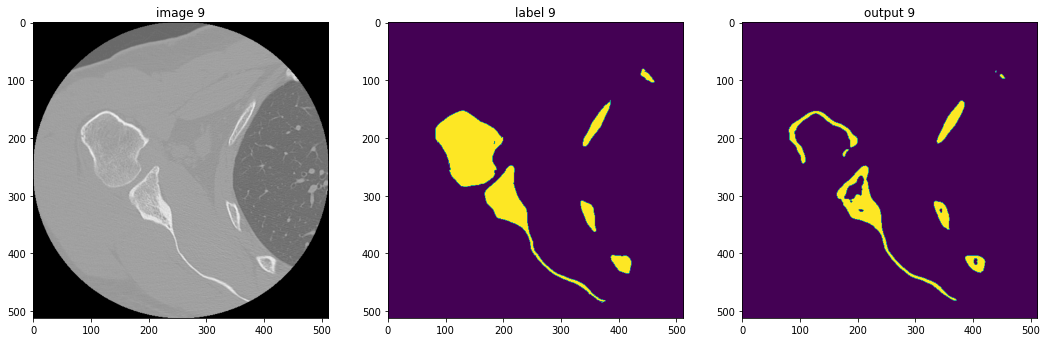

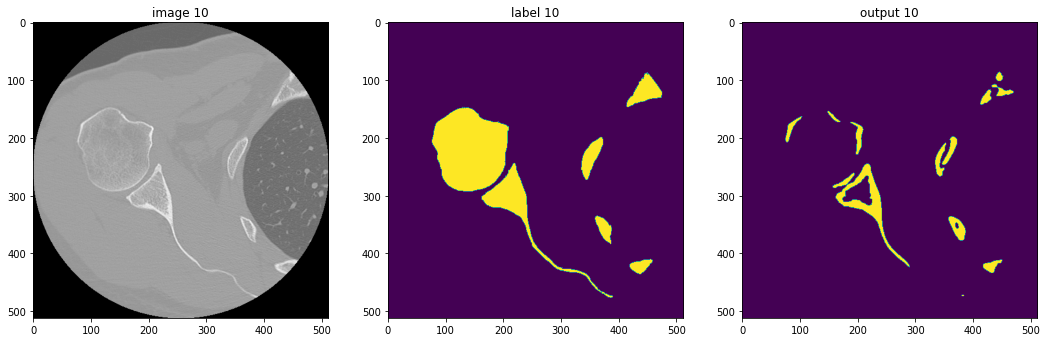

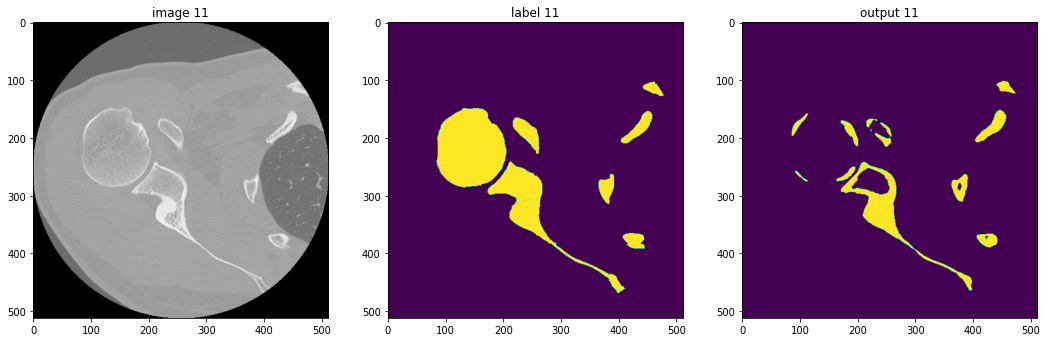

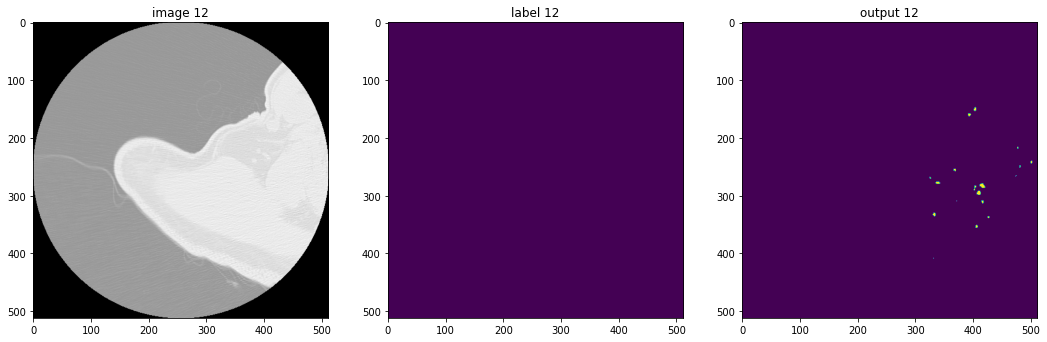

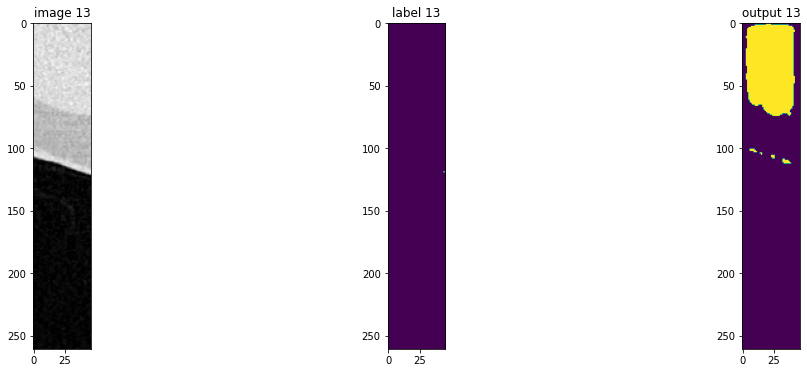

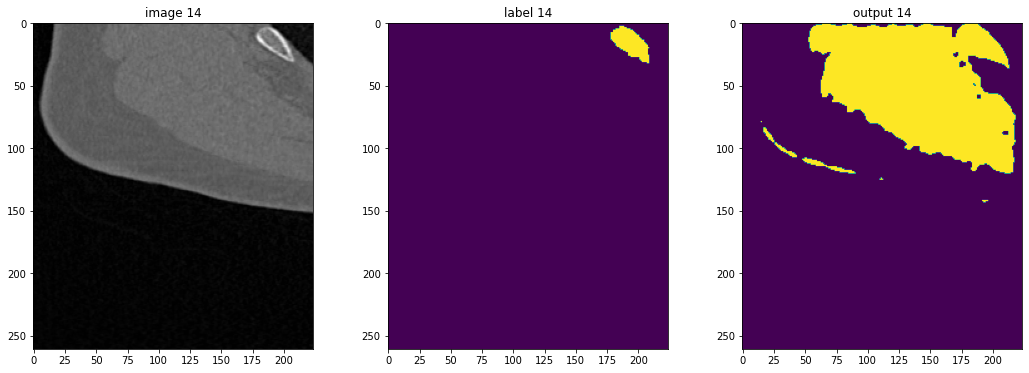

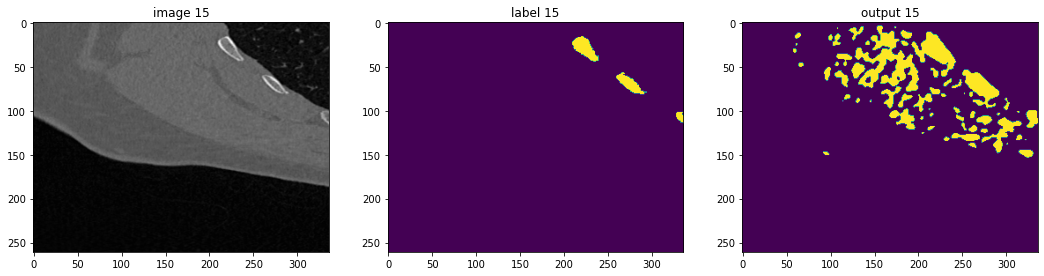

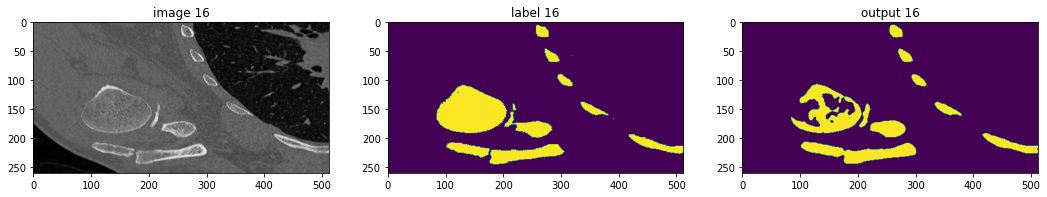

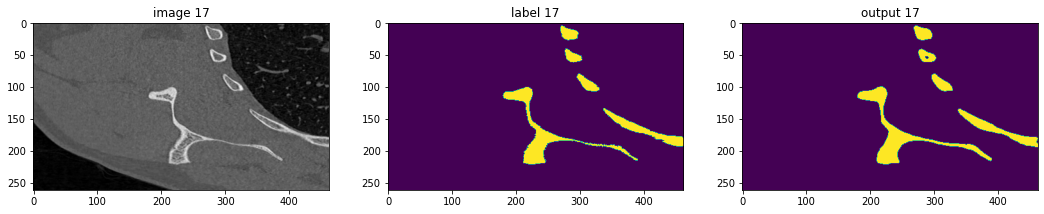

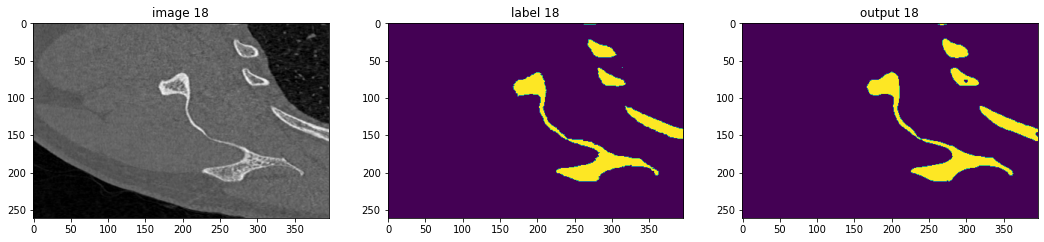

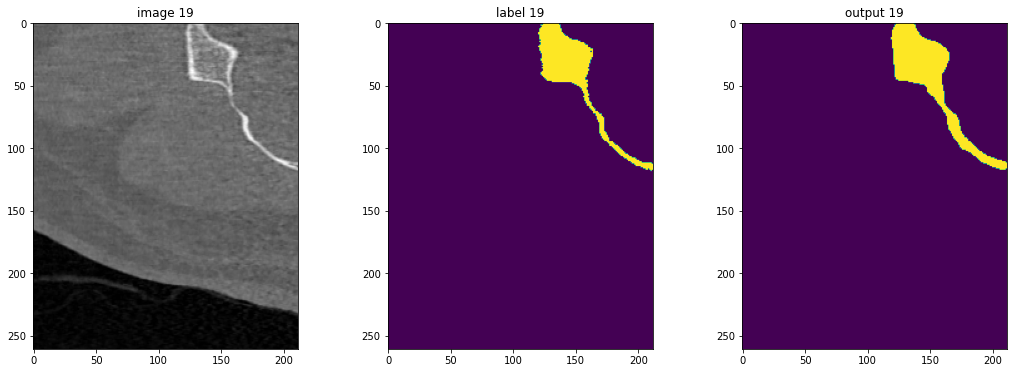

In [77]:
net.eval()
device = torch.device("cuda:0")
net.to(device)
with torch.no_grad():
    for i, val_data in enumerate(net.val_dataloader()):
        roi_size = (512, 512)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, net
        )
        
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :])
        plt.show()